## Compile Figure 3

In figure 3, we present a grit application in a CRISPRi perturbseq dataset

1. Panel A - Strong correlation between grit and relative activity in genes
2. Panel B - Select single cells across activity ranges

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source(file.path("utils", "themes.R"))

In [2]:
# Load perturbseq results
perturbseq_results_dir <- file.path("../1.calculate-metrics/perturb-seq/results")

gse_id <- "GSE132080"
results_file <- file.path(perturbseq_results_dir, paste0(gse_id, "_grit.tsv"))

output_dir <- "figures"

In [3]:
# Load bulk data
bulk_grit_cols <- readr::cols(
    perturbation = readr::col_character(),
    group = readr::col_character(),
    grit = readr::col_double(),
    id = readr::col_character(),
    sequence = readr::col_character(),
    gene = readr::col_character(),
    gamma_day5 = readr::col_double(),
    gamma_day10 = readr::col_double(),
    relative_activity_day5 = readr::col_double(),
    relative_activity_day10 = readr::col_double()
)

bulk_grit_df <- readr::read_tsv(results_file, col_types = bulk_grit_cols)

# Order for plotting
bulk_grit_df$gene <- factor(bulk_grit_df$gene, levels = unique(bulk_grit_df$gene))

print(dim(bulk_grit_df))
head(bulk_grit_df)

[1] 128  10


perturbation,group,grit,id,sequence,gene,gamma_day5,gamma_day10,relative_activity_day5,relative_activity_day10
<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HSPA5_HSPA5_+_128003624.23-P1P2_01,HSPA5,27.97864,HSPA5_+_128003624.23-P1P2_01,GAACCGAGTAGGCGACGGTG,HSPA5,-0.6373270,-0.3748080,0.8524606,0.8773974
GATA1_GATA1_-_48645022.23-P1P2_00,GATA1,27.38178,GATA1_-_48645022.23-P1P2_00,GTGAGCTTGCCACATCCCCA,GATA1,-0.9627320,-0.6153056,1.0000000,1.0000000
HSPA5_HSPA5_+_128003624.23-P1P2_04,HSPA5,27.11126,HSPA5_+_128003624.23-P1P2_04,GAGCCGAGAAGGCGACGGTG,HSPA5,-0.7544022,-0.4224809,1.0090552,0.9889960
HSPA5_HSPA5_+_128003624.23-P1P2_08,HSPA5,26.31013,HSPA5_+_128003624.23-P1P2_08,GAGCCGAGTGGGCGACGGTG,HSPA5,-0.7565658,-0.4434939,1.0119492,1.0381860
RPL9_RPL9_+_39460483.23-P1P2_01,RPL9,25.36361,RPL9_+_39460483.23-P1P2_01,GGATGATTCTGTGCTCGTGG,RPL9,-0.8528002,-0.4984321,0.7661382,0.7440656
GATA1_GATA1_-_48645022.23-P1P2_03,GATA1,25.28785,GATA1_-_48645022.23-P1P2_03,GTGCGCTTGCCACATCCCCA,GATA1,-0.9854792,-0.6259106,1.0236277,1.0172352


In [4]:
# Load single cell grit results
sc_results_file <- file.path(perturbseq_results_dir, paste0(gse_id, "_single_cell_grit.tsv.gz"))

sc_grit_cols <- readr::cols(
    perturbation = readr::col_character(),
    group = readr::col_character(),
    grit = readr::col_double(),
    grit_gene = readr::col_character(),
    grit_guide = readr::col_character()
)

sc_df <- readr::read_tsv(sc_results_file, col_types = sc_grit_cols)

# Load UMAP embeddings
sc_embeddings_file <- file.path(perturbseq_results_dir, paste0(gse_id, "_single_cell_umap_embeddings.tsv.gz"))

sc_embeddings_cols <- readr::cols(
    Metadata_cell_identity = readr::col_character(),
    Metadata_cell_barcode = readr::col_character(),
    Metadata_guide_identity = readr::col_character(),
    Metadata_read_count = readr::col_double(),
    Metadata_UMI_count = readr::col_double(),
    Metadata_coverage = readr::col_double(),
    Metadata_gemgroup = readr::col_double(),
    Metadata_good_coverage = readr::col_logical(),
    Metadata_number_of_cells = readr::col_double(),
    Metadata_gene_identity = readr::col_character(),
    Metadata_barcode = readr::col_character(),
    Metadata_sequence = readr::col_character(),
    umap_0 = readr::col_double(),
    umap_1 = readr::col_double(),
    grit_gene = readr::col_character()
)

sc_embeddings_df <- readr::read_tsv(sc_embeddings_file, col_types = sc_embeddings_cols)

In [5]:
# Merge single cell data
sc_df <- sc_embeddings_df %>%
    dplyr::right_join(
        sc_df,
        by = c("Metadata_cell_identity" = "perturbation", "grit_gene" = "grit_gene")
    ) %>%
    dplyr::full_join(
        bulk_grit_df,
        by = c("Metadata_guide_identity" = "perturbation", "Metadata_gene_identity" = "gene"),
        suffix = c("", "_bulk_activity"),
        keep = TRUE
)

sc_df$gene = factor(sc_df$gene, levels = unique(bulk_grit_df$gene))

sc_df$Metadata_gene_identity = factor(
    sc_df$Metadata_gene_identity, levels = c("neg", paste(unique(bulk_grit_df$gene)))
)

print(dim(sc_df))
head(sc_df)

[1] 83105    28


Metadata_cell_identity,Metadata_cell_barcode,Metadata_guide_identity,Metadata_read_count,Metadata_UMI_count,Metadata_coverage,Metadata_gemgroup,Metadata_good_coverage,Metadata_number_of_cells,Metadata_gene_identity,⋯,perturbation,group_bulk_activity,grit_bulk_activity,id,sequence,gene,gamma_day5,gamma_day10,relative_activity_day5,relative_activity_day10
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<fct>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
sc_profile_0,AAACCTGAGAGTAATC-1,RAN_RAN_+_131356438.23-P1P2_12,544,34,16.00000,1,TRUE,1,RAN,⋯,RAN_RAN_+_131356438.23-P1P2_12,RAN,-4.0757099,RAN_+_131356438.23-P1P2_12,GGCGGTCGCTGCGCTTAGGT,RAN,-0.04654856,-0.03425914,0.2358226,0.2121552
sc_profile_165,AACGTTGAGAGTAATC-1,RAN_RAN_+_131356438.23-P1P2_00,625,36,17.36111,1,TRUE,2,RAN,⋯,RAN_RAN_+_131356438.23-P1P2_00,RAN,1.4400602,RAN_+_131356438.23-P1P2_00,GGCGGTCGCTGCGCTTAGGG,RAN,-0.19738803,-0.16148153,1.0000000,1.0000000
sc_profile_264,AACTTTCTCTAAGCCA-1,RAN_RAN_+_131356438.23-P1P2_04,334,19,17.57895,1,TRUE,1,RAN,⋯,RAN_RAN_+_131356438.23-P1P2_04,RAN,0.9436349,RAN_+_131356438.23-P1P2_04,GGCGGTCGCGGCGCTTAGGG,RAN,-0.08590181,-0.08721057,0.4351926,0.5400653
sc_profile_311,AAGGAGCCATGCGCAC-1,RAN_RAN_+_131356438.23-P1P2_02,405,22,18.40909,1,TRUE,1,RAN,⋯,RAN_RAN_+_131356438.23-P1P2_02,RAN,3.1477690,RAN_+_131356438.23-P1P2_02,GGCGGCCGCTGCGCTTAGGG,RAN,-0.23159425,-0.20413453,1.1732943,1.2641355
sc_profile_314,AAGGAGCTCCTGTAGA-1,RAN_RAN_+_131356438.23-P1P2_04,926,41,22.58537,1,TRUE,1,RAN,⋯,RAN_RAN_+_131356438.23-P1P2_04,RAN,0.9436349,RAN_+_131356438.23-P1P2_04,GGCGGTCGCGGCGCTTAGGG,RAN,-0.08590181,-0.08721057,0.4351926,0.5400653
sc_profile_353,AAGGTTCTCTTTAGTC-1,RAN_RAN_+_131356438.23-P1P2_12,619,30,20.63333,1,TRUE,1,RAN,⋯,RAN_RAN_+_131356438.23-P1P2_12,RAN,-4.0757099,RAN_+_131356438.23-P1P2_12,GGCGGTCGCTGCGCTTAGGT,RAN,-0.04654856,-0.03425914,0.2358226,0.2121552


In [6]:
table(sc_df$gene)


  HSPA5   GATA1    RPL9   GINS1   HSPA9  EIF2S1     BCR     CAD  GNB2L1  POLR1D 
    745     577     608     900     542     614     869     874    1006    1375 
 POLR2H SEC61A1   HSPE1     DUT    TUBB   RPS14   RPS18   RPS15    MTOR   CDC23 
    494     828     977    1243     672     960     628     693     964     829 
   DBR1     RAN   ATP5E   ALDOA   COX11 
   1107     875     832     625     932 

In [7]:
table(sc_df$Metadata_gene_identity)


    neg   HSPA5   GATA1    RPL9   GINS1   HSPA9  EIF2S1     BCR     CAD  GNB2L1 
  62336     745     577     608     900     542     614     869     874    1006 
 POLR1D  POLR2H SEC61A1   HSPE1     DUT    TUBB   RPS14   RPS18   RPS15    MTOR 
   1375     494     828     977    1243     672     960     628     693     964 
  CDC23    DBR1     RAN   ATP5E   ALDOA   COX11 
    829    1107     875     832     625     932 

In [8]:
# Load single cell gene expression data
perturbseq_data_dir <- file.path("../0.download-data/data/perturbseq/")

gene_exp_file <- file.path(perturbseq_data_dir, paste0(gse_id, "_final_analytical.tsv.gz"))

sc_gene_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_cell_identity = readr::col_character(),
    Metadata_cell_barcode = readr::col_character(),
    Metadata_guide_identity = readr::col_character(),
    Metadata_good_coverage = readr::col_logical(),
    Metadata_gene_identity = readr::col_character(),
    Metadata_barcode = readr::col_character(),
    Metadata_sequence = readr::col_character()
)

sc_gene_exp_df <- readr::read_tsv(gene_exp_file, col_types = sc_gene_cols)

print(dim(sc_gene_exp_df))
head(sc_gene_exp_df)

[1] 23537  1012


Metadata_cell_identity,Metadata_cell_barcode,Metadata_guide_identity,Metadata_read_count,Metadata_UMI_count,Metadata_coverage,Metadata_gemgroup,Metadata_good_coverage,Metadata_number_of_cells,Metadata_gene_identity,⋯,YPEL4,YPEL5,ZBTB38,ZFAS1,ZFP36L1,ZNF365,ZNF43,ZNF483,ZNF556,ZYX
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sc_profile_0,AAACCTGAGAGTAATC-1,RAN_RAN_+_131356438.23-P1P2_12,544,34,16.00000,1,TRUE,1,RAN,⋯,-0.09309015,-0.6324684,-0.539091,-1.6338047,-0.87691170,-0.01215485,-0.01776344,-0.02687659,-0.05239976,-0.452229
sc_profile_1,AAACCTGAGGGATCTG-1,neg_ctrl_non-targeting_00089,267,19,14.05263,1,TRUE,1,neg,⋯,-0.09309015,-0.6324684,-0.539091,1.6102196,1.32226532,-0.01215485,-0.01776344,-0.02687659,-0.05239976,-0.452229
sc_profile_2,AAACCTGAGGTCATCT-1,POLR2H_POLR2H_+_184081251.23-P1P2_08,622,34,18.29412,1,TRUE,1,POLR2H,⋯,-0.09309015,-0.6324684,-0.539091,-0.5672524,0.05754019,-0.01215485,-0.01776344,-0.02687659,-0.05239976,-0.452229
sc_profile_3,AAACCTGCAATGGAGC-1,TUBB_TUBB_+_30688126.23-P1_03,433,20,21.65000,1,TRUE,1,TUBB,⋯,-0.09309015,1.7652789,-0.539091,-1.6594202,-0.87691170,-0.01215485,-0.01776344,-0.02687659,-0.05239976,-0.452229
sc_profile_4,AAACCTGCACCAGGCT-1,CDC23_CDC23_-_137548987.23-P1P2_04,136,8,17.00000,1,TRUE,1,CDC23,⋯,-0.09309015,0.6867527,-0.539091,0.5412597,0.93453878,-0.01215485,-0.01776344,-0.02687659,-0.05239976,1.406718
sc_profile_5,AAACCTGCACCATCCT-1,POLR1D_POLR1D_+_28196016.23-P1_08,3,1,3.00000,1,FALSE,0,POLR1D,⋯,-0.09309015,-0.6324684,-0.539091,-0.6335042,0.38649400,-0.01215485,-0.01776344,-0.02687659,-0.05239976,-0.452229


## Panel A

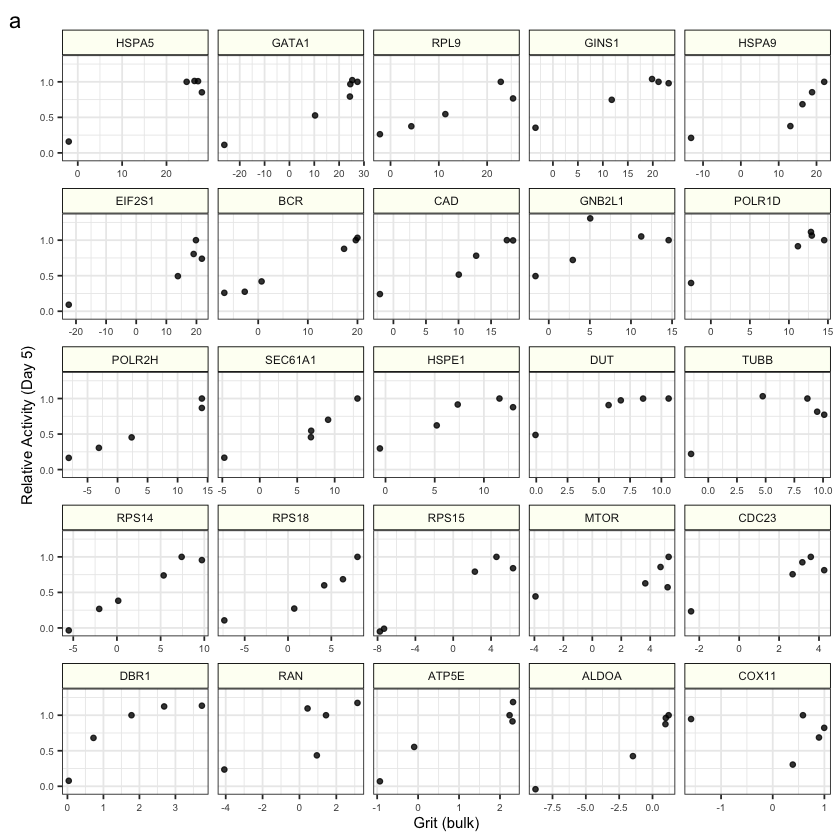

In [9]:
bulk_gene_gg = (
    ggplot(bulk_grit_df, aes(y = relative_activity_day5, x = grit))
    + geom_point(size = 1.2, alpha = 0.8)
    + xlab("Grit (bulk)")
    + ylab("Relative Activity (Day 5)")
    + facet_wrap("~gene", scales = "free_x")
    + custom_grit_theme
    + theme(axis.text = element_text(size = 6))
    + labs(tag = "a")
)

bulk_gene_gg

## Panel B

In [10]:
top_genes <- c("HSPA5", "GATA1", "RPL9", "GINS1", "HSPA9")

In [11]:
top_gene_embeddings <- list()
gene_ggs <- list()

for (gene in top_genes) {
    gene_embedding_df <- sc_df %>%
        dplyr::filter(grit_gene == !!gene) %>%
        dplyr::mutate(grit_facet_label = paste("RA:", round(relative_activity_day5, 3)))

    gene_neg_ctrl <- "Neg. Ctrl"
    gene_embedding_df[gene_embedding_df$Metadata_gene_identity == "neg", "grit_facet_label"] <- gene_neg_ctrl

    factor_order <- c(gene_neg_ctrl, paste("RA:", unique(round(sort(gene_embedding_df$relative_activity_day5), 3))))

    gene_embedding_df$grit_facet_label <- factor(
        gene_embedding_df$grit_facet_label, levels = factor_order
    )
    
    top_gene_embeddings[[gene]] <- gene_embedding_df
    
    gene_gg = (
        ggplot(gene_embedding_df, aes(x = umap_0, y = umap_1))
        + geom_point(aes(fill = grit), size = 1.8, pch = 21, stroke = 0, alpha = 0.5)
        + facet_grid("grit_facet_label~grit_gene", scales = "free", as.table = TRUE)
        + custom_grit_theme
        + xlab("")
        + ylab("")
        + theme(
            plot.margin = margin(t = 0.25, r = 0, b = 0.25, l = -0.7, "cm"),
            axis.text = element_text(size = 6),
        )
    )
    
    if (gene == "HSPA5") {
        gene_gg <- gene_gg + ylab("UMAP 1") + labs(tag = "b")
    }
    
    gene_ggs[[gene]] <- gene_gg
}

top_gene_embeddings <- dplyr::bind_rows(top_gene_embeddings)

print(dim(top_gene_embeddings))
head(top_gene_embeddings)

[1] 16034    29


Metadata_cell_identity,Metadata_cell_barcode,Metadata_guide_identity,Metadata_read_count,Metadata_UMI_count,Metadata_coverage,Metadata_gemgroup,Metadata_good_coverage,Metadata_number_of_cells,Metadata_gene_identity,⋯,group_bulk_activity,grit_bulk_activity,id,sequence,gene,gamma_day5,gamma_day10,relative_activity_day5,relative_activity_day10,grit_facet_label
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<fct>,⋯,<chr>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
sc_profile_7,AAACCTGCAGTGGGAT-1,HSPA5_HSPA5_+_128003624.23-P1P2_00,278,11,25.27273,1,TRUE,1,HSPA5,⋯,HSPA5,24.541126,HSPA5_+_128003624.23-P1P2_00,GAGCCGAGTAGGCGACGGTG,HSPA5,-0.7476322,-0.42718160,1.0000000,1.0000000,RA: 1
sc_profile_24,AAACGGGCACCAGCAC-1,HSPA5_HSPA5_+_128003624.23-P1P2_08,1287,68,18.92647,1,TRUE,1,HSPA5,⋯,HSPA5,26.310133,HSPA5_+_128003624.23-P1P2_08,GAGCCGAGTGGGCGACGGTG,HSPA5,-0.7565658,-0.44349394,1.0119492,1.0381860,RA: 1.012
sc_profile_59,AAAGCAAAGATCGGGT-1,HSPA5_HSPA5_+_128003624.23-P1P2_04,295,19,15.52632,1,TRUE,1,HSPA5,⋯,HSPA5,27.111261,HSPA5_+_128003624.23-P1P2_04,GAGCCGAGAAGGCGACGGTG,HSPA5,-0.7544022,-0.42248089,1.0090552,0.9889960,RA: 1.009
sc_profile_91,AAAGTAGTCTGCGTAA-1,HSPA5_HSPA5_+_128003624.23-P1P2_08,445,25,17.80000,1,TRUE,2,HSPA5,⋯,HSPA5,26.310133,HSPA5_+_128003624.23-P1P2_08,GAGCCGAGTGGGCGACGGTG,HSPA5,-0.7565658,-0.44349394,1.0119492,1.0381860,RA: 1.012
sc_profile_111,AACACGTCAGGGTATG-1,HSPA5_HSPA5_+_128003624.23-P1P2_08,715,33,21.66667,1,TRUE,2,HSPA5,⋯,HSPA5,26.310133,HSPA5_+_128003624.23-P1P2_08,GAGCCGAGTGGGCGACGGTG,HSPA5,-0.7565658,-0.44349394,1.0119492,1.0381860,RA: 1.012
sc_profile_129,AACCATGGTCCAGTTA-1,HSPA5_HSPA5_+_128003624.23-P1P2_06,922,48,19.20833,1,TRUE,1,HSPA5,⋯,HSPA5,-2.035275,HSPA5_+_128003624.23-P1P2_06,GAGCCGAGTAGACGACGGTG,HSPA5,-0.1191640,-0.09835161,0.1593885,0.2302337,RA: 0.159


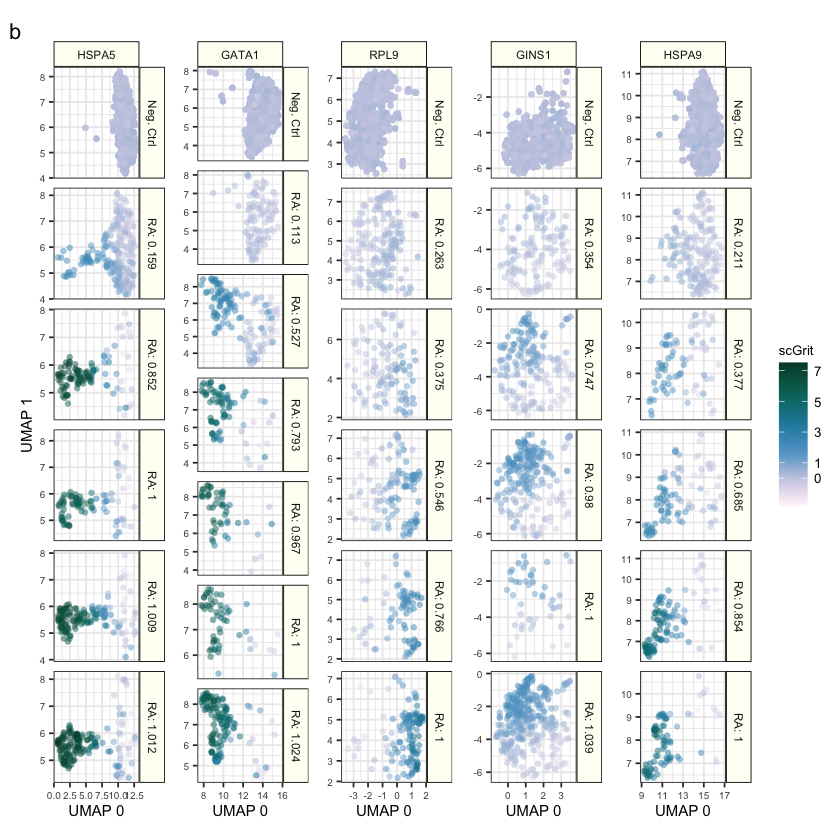

In [12]:
grit_range <- range(top_gene_embeddings$grit, na.rm = TRUE)

sc_grit_gg <- wrap_plots(gene_ggs, ncol = length(gene_ggs)) +
    plot_layout(guides = "collect") & 
    scale_colour_continuous(limits = grit_range) &
    xlab("UMAP 0") &
    scale_fill_gradientn(
        name = "scGrit",
        colors = scgrit_palette(10),
        values = scales::rescale(c(max(grit_range) + 1, 3, 0)),
        breaks = c(0, 1, 3, 5, 7),
        limits = grit_range
    )

sc_grit_gg

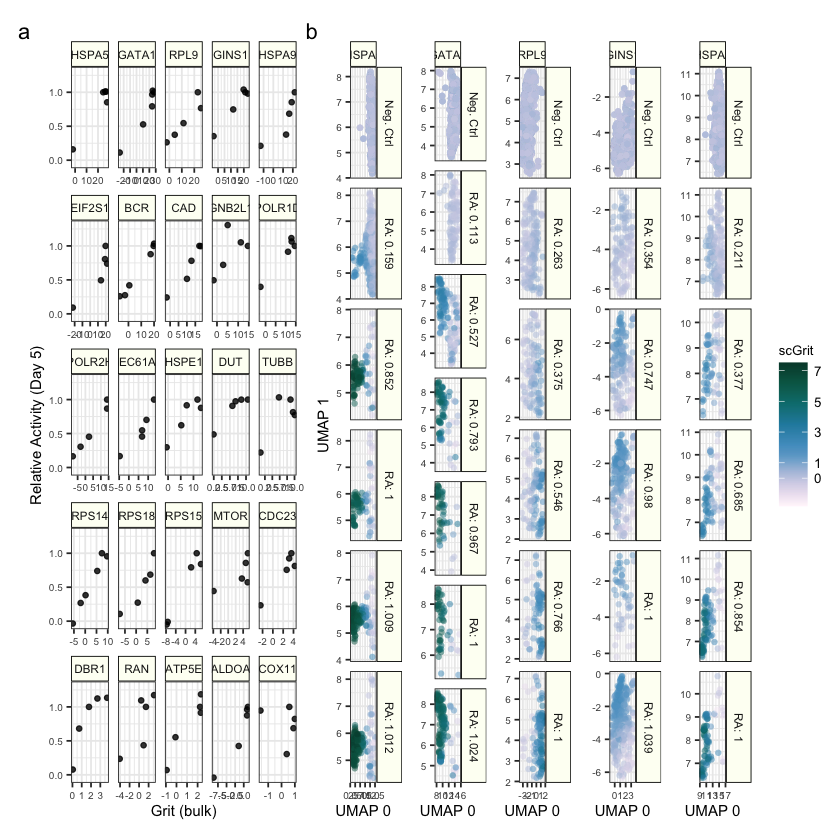

In [13]:
patchwork_plot <- (bulk_gene_gg | sc_grit_gg) + plot_layout(widths = c(0.6, 1))

for (extension in c(".png", ".pdf")) {
    output_file <- file.path(output_dir, paste0("figure3", extension))
    ggsave(output_file, patchwork_plot, width = 12, height = 6.2)
}

patchwork_plot